In [52]:
from qiskit import *

In [53]:
circuit = QuantumCircuit(3,3)
# QUBIT ORDERING
# q0 = State |psi> that we want to teleport
# q1 = Alice's half of the Bell pair
# q2 = Bob's half of the Bell pair, the destination of the teleportation

# ========================
# Step 0: Create the state to be teleported in qubit 0
circuit.x(0) # qubit 0 is now in state |1>, and this is the state that we want to teleport

circuit.barrier() # just a visual aid

# ========================
# Step 1: create an entangled Bell pair between Alice and Bob (qubits 1 and 2)
circuit.h(1)
circuit.cx(1,2)

circuit.barrier() # just a visual aid

# ========================
# Step 2: Alice applies a series of operations 
# between the state to teleport (qubit 0) and her half of the Bell pair (qubit 1)
circuit.cx(0,1)
circuit.h(0)

circuit.barrier() # just a visual aid

# ========================
# Step 3: Alice measures both qubits 0 and 1
circuit.measure([0, 1], [0, 1]) # results stored in classical bits 0 and 1, respectively

circuit.barrier() # just a visual aid

# ========================
# Step 4: Now that Alice has measured the two qubits, their states have collapsed to 0 and 1. 
# Bob can do operations conditioned on these qubits to his half of the Bell pair
# Note that while we're conditioning Bob's operation on the collapsed qubits 0 and 1, we can
# do teleportation over long distances by transmitting the classical information in classical bits 0 and 1
circuit.cx(1, 2)
circuit.cz(0, 2)

# Step 5: Done! Measure Bob's qubit to find out what state it is in
circuit.measure([2], [2])

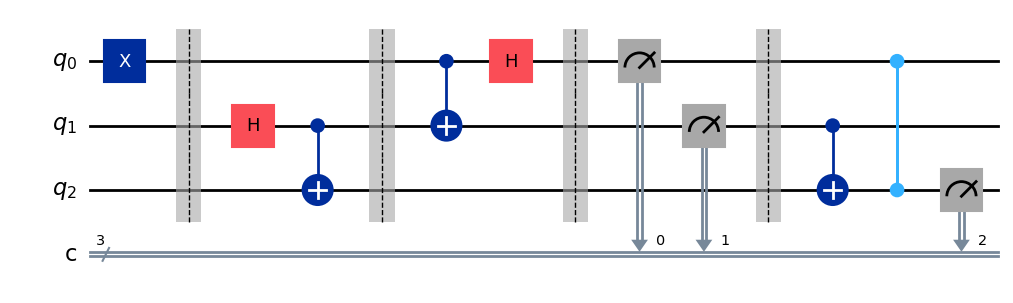

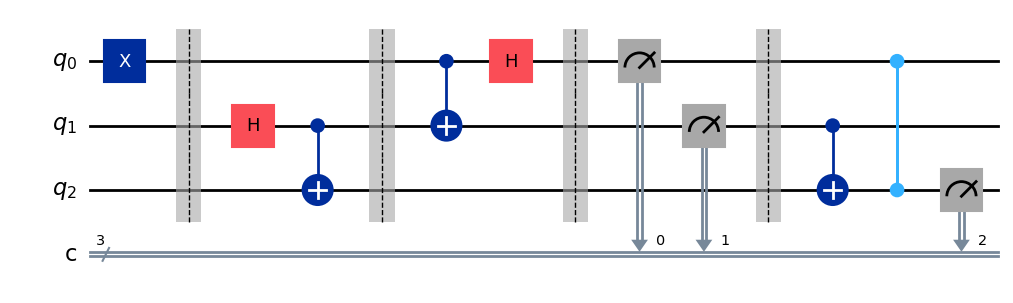

In [54]:
%matplotlib inline
circuit.draw(output='mpl')

     ┌───┐          ┌───┐ ░            ┌─┐   
q_0: ┤ X ├───────■──┤ H ├─░───────■────┤M├───
     ├───┤     ┌─┴─┐└───┘ ░       │ ┌─┐└╥┘   
q_1: ┤ H ├──■──┤ X ├──────░───■───┼─┤M├─╫────
     └───┘┌─┴─┐└───┘      ░ ┌─┴─┐ │ └╥┘ ║ ┌─┐
q_2: ─────┤ X ├───────────░─┤ X ├─■──╫──╫─┤M├
          └───┘           ░ └───┘    ║  ║ └╥┘
c: 3/════════════════════════════════╩══╩══╩═
                                     1  0  2 
{'111': 271, '101': 283, '100': 227, '110': 243}


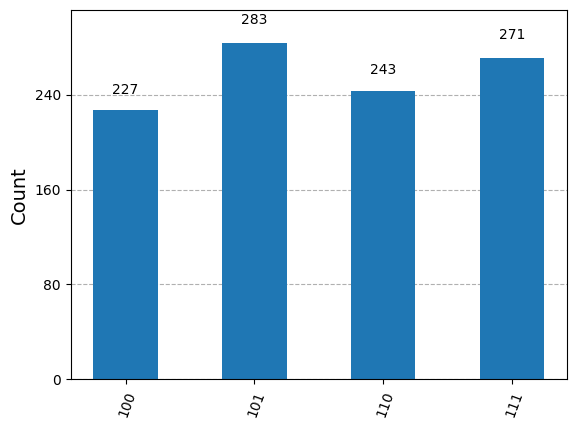

In [55]:
import qiskit as q
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit import transpile

# Create a circuit with 3 qubits and 3 classical bits.
circuit = q.QuantumCircuit(3, 3)

# --- Teleportation Circuit Setup ---

# (Optional) Initialize qubit 0 to |1> so we teleport state |1>.
circuit.x(0)

# Step 1: Create an entangled pair between qubits 1 & 2.
circuit.h(1)
circuit.cx(1, 2)

# Step 2: Perform Bell measurement on qubits 0 and 1.
circuit.cx(0, 1)
circuit.h(0)

# Barrier separating measurement and correction.
circuit.barrier()

# Step 3: Apply correction operations.
circuit.cx(1, 2)
circuit.cz(0, 2)

# Step 4: Measure all qubits.
# Mapping: Q0 -> c0, Q1 -> c1, Q2 -> c2.
circuit.measure([0, 1, 2], [0, 1, 2])

print(circuit)

# --- Simulation using AerSimulator ---
backend = AerSimulator()
# Transpile the circuit for the chosen backend.
tqc = transpile(circuit, backend=backend)
# Run the circuit with 1024 shots.
job = backend.run(tqc, shots=1024)
result = job.result()

# Get counts from the result.
counts = result.get_counts()
plot_histogram(counts)

print(counts)
num_c2_zero = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '0')


c:\Users\ASURA\Desktop\Quantum Computing\qiskit-env\Lib\site-packages\qiskit\circuit\quantumcircuit.py:3428: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


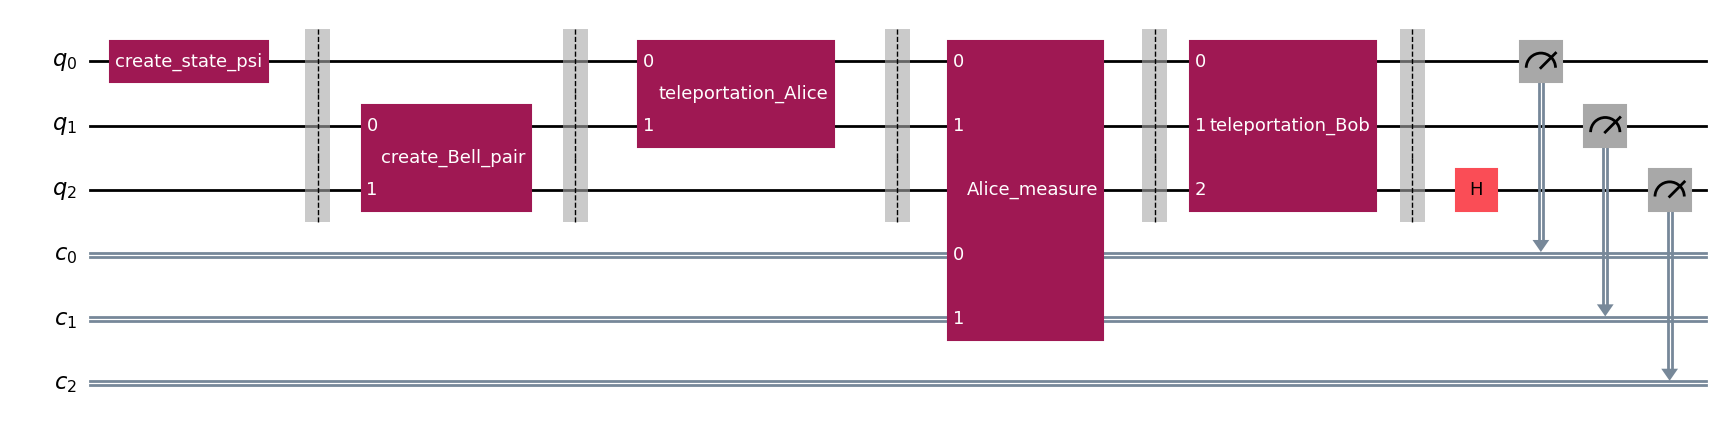

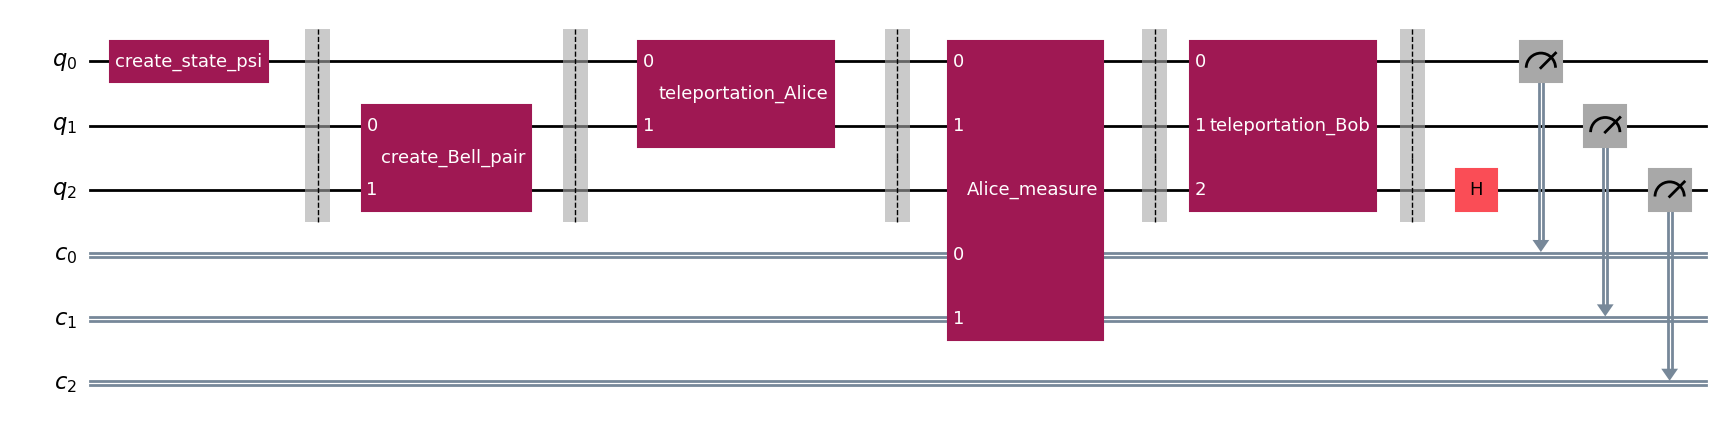

In [56]:
def create_state_psi(theta):
    # Create a state along the x axis on the x-y plane and then rotate it by angle theta around the z-axis
    # theta = 0 => state is exactly along x
    # theta = pi/2 => state is exactly along y
    create_circuit = QuantumCircuit(1, name='create_state_psi')
    create_circuit.h(0)
    create_circuit.rz(theta, 0)
    return create_circuit

def create_Bell_pair():
    create_Bell_circuit = QuantumCircuit(2, name='create_Bell_pair')
    create_Bell_circuit.h(0)
    create_Bell_circuit.cx(0,1)
    return create_Bell_circuit

def teleportation_Alice():
    teleportation_Alice_circuit = QuantumCircuit(2, name='teleportation_Alice')
    teleportation_Alice_circuit.cx(0,1)
    teleportation_Alice_circuit.h(0)
    return teleportation_Alice_circuit

def Alice_measure():
    Alice_measure_circuit = QuantumCircuit(2, 2, name='Alice_measure')
    Alice_measure_circuit.measure([0,1], [0,1])
    return Alice_measure_circuit

def teleportation_Bob():
    teleportation_Bob_circuit = QuantumCircuit(3, name='teleportation_Bob')
    teleportation_Bob_circuit.cx(1,2)
    teleportation_Bob_circuit.cz(0,2)
    return teleportation_Bob_circuit

def build_circuit(theta):
    circuit = QuantumCircuit(3, 3)
    # Step 0: create the state to teleport
    circuit.append(create_state_psi(theta).to_instruction(), [0])
    circuit.barrier()
    # Step 1: create the Bell pair between Alice and Bob's qubits
    circuit.append(create_Bell_pair().to_instruction(), [1,2])
    circuit.barrier()
    # Step 2: Alice applies a series of operations
    circuit.append(teleportation_Alice().to_instruction(), [0,1])
    circuit.barrier()
    # Step 3: Alice measures her two qubits
    circuit.append(Alice_measure().to_instruction(), [0,1], [0,1])
    circuit.barrier()
    # Step 4: Bob applies operations to his qubit depending on Alice's measurement outcomes
    circuit.append(teleportation_Bob().to_instruction(), [0,1,2])
    circuit.barrier()
    # Step 5: Done. Now measure Bob's qubit to be sure that teleportation was successful
    circuit.h(2) # note that the Hadamard gate here ensures that we measure in the Hadamard basis instead of z basis
    circuit.measure([0,1,2], [0,1,2])
    return circuit

circuit = build_circuit(0.01)
circuit.draw(output='mpl')

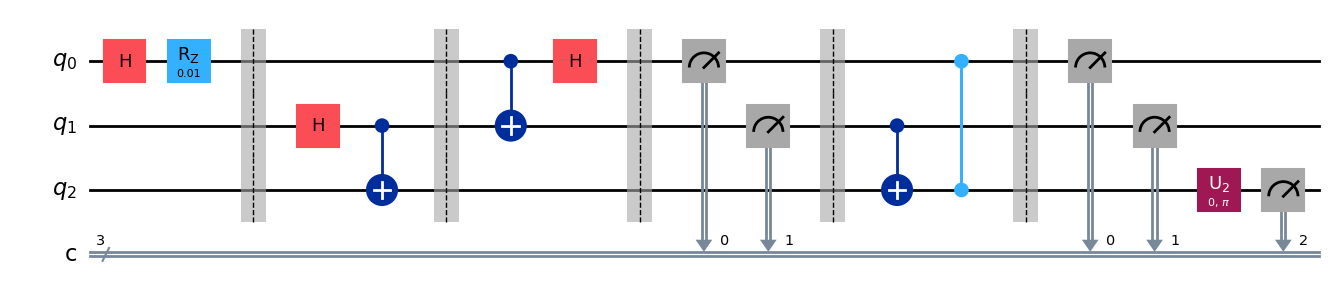

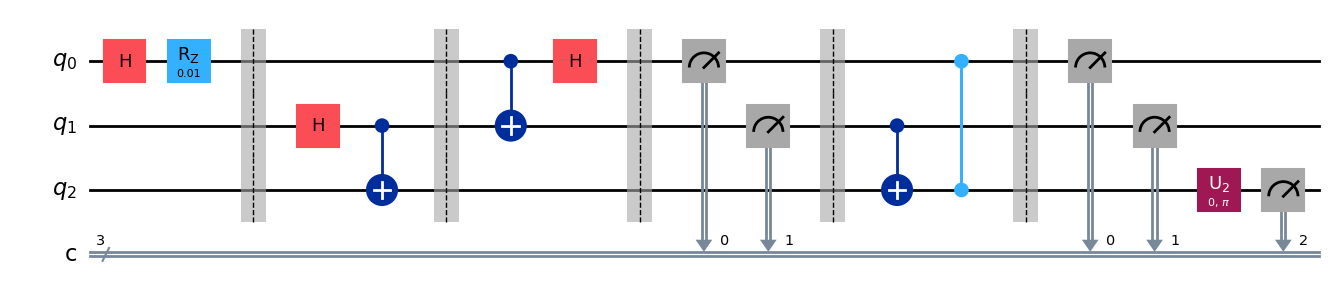

In [57]:
circuit.decompose().draw(output='mpl')

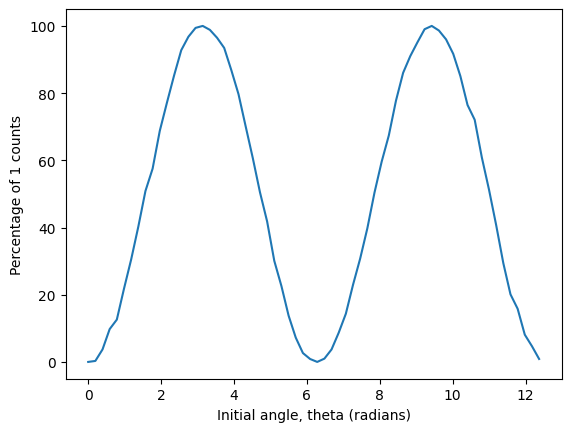

In [58]:
import numpy as np
thetas = np.arange(0, 4*np.pi, np.pi/16)

# --- Simulation using AerSimulator ---
backend = AerSimulator()

percent_ones = []

for theta in thetas:
    circuit = build_circuit(theta)
    # Transpile the circuit for the chosen backend.
    tqc = transpile(circuit, backend=backend)
    # Run the circuit with 1024 shots.
    job = backend.run(tqc, shots=1024)
    result = job.result()
    counts = result.get_counts(circuit)
    num_c2_ones = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '1')
    percent_ones.append(num_c2_ones*100./1024)
    
import matplotlib.pyplot as plotter
plotter.plot(thetas, percent_ones)
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.show()

In [59]:
# build circuits
thetas = np.arange(0, 4*np.pi, np.pi/16)

circuits = []
for theta in thetas:
    circuit = build_circuit(theta)
    circuits.append(circuit)

In [60]:
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account("51d843421456b6ef179496703907f6319cf555dc54444bfa3e35bf4ba5e3a36280a6a1cc36fe307bdefc7192b0d1e778ebb7180277c50a6976573382efb8644a", overwrite=True)
